In [113]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import geopandas as gpd
from sklearn.metrics.pairwise import euclidean_distances
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [114]:
# read in the data 
data = pd.read_csv('Datasets/combined_data.csv')
data.head()

,Cst_Cnt,Sta_ID,ChlorA,Phaeop,T_degC,Salnty,O2ml_L,PO4uM,SiO3uM,NO3uM,...,Julian_Day,Lat_Dec,Lon_Dec,Julian_Date,Wind_Spd,Wave_Ht,Dry_T,Wave_Prd,Barometer,YearMonth
0,1,054.0 056.0,NaN,NaN,8.414828,33.770571,NaN,NaN,NaN,NaN,...,60,38.833333,-124.083333,17958.0,18.0,NaN,NaN,NaN,NaN,1949-03
1,2,052.0 075.0,NaN,NaN,6.612188,33.811156,NaN,NaN,NaN,NaN,...,60,38.583333,-125.800000,17958.0,5.0,NaN,NaN,NaN,NaN,1949-03
2,3,051.0 085.0,NaN,NaN,7.291935,33.505419,NaN,NaN,NaN,NaN,...,61,38.475000,-126.666666,17959.0,5.0,NaN,NaN,NaN,NaN,1949-03
3,4,050.0 095.0,NaN,NaN,7.437742,33.563267,NaN,NaN,NaN,NaN,...,61,38.333333,-127.516666,17959.0,8.0,NaN,NaN,NaN,NaN,1949-03
4,5,050.0 104.0,NaN,NaN,8.095385,33.438200,NaN,NaN,NaN,NaN,...,61,38.233333,-128.366666,17959.0,13.0,NaN,NaN,NaN,NaN,1949-03


In [115]:
# filter out other data
data = data[['Julian_Date', 'Sta_ID', 'ChlorA', 'Lat_Dec', 'Lon_Dec']]
data = data.dropna()

In [116]:
# Function to round the second part of Sta_ID to the nearest 10
def round_sta_id(value):
    parts = value.split()  # Split the Sta_ID into components
    rounded_parts = [
        f"{float(part):.1f}" if i == 0 else f"{10 * round(float(part) / 10):.1f}"
        for i, part in enumerate(parts)
    ]
    return " ".join(rounded_parts)

# Apply the rounding function to the Sta_ID column
data['Sta_ID'] = data['Sta_ID'].apply(round_sta_id)

# Display the updated DataFrame
data

,Julian_Date,Sta_ID,ChlorA,Lat_Dec,Lon_Dec
18831,26731.0,133.0 40.0,0.650000,25.850000,-113.500000
18832,26733.0,142.7 10.0,2.483333,25.026666,-110.750000
18833,26733.0,142.0 10.0,0.240000,25.093333,-110.783333
18834,26734.0,120.0 10.0,2.425000,28.856666,-113.258333
18835,26735.0,120.0 10.0,5.540909,28.878333,-113.191666
...,...,...,...,...,...
35639,44321.0,93.3 60.0,0.441000,31.846300,-119.565900
35640,44322.0,93.3 70.0,0.296533,31.515130,-120.240520
35641,44322.0,93.3 80.0,0.214667,31.176820,-120.920900
35642,44322.0,93.3 90.0,0.235235,30.846380,-121.589030


In [117]:
unique_stations = data['Sta_ID'].nunique()
unique_stations

510

In [118]:
# Define the grouping logic
grouped_dates = []
current_group = []

for idx, date in enumerate(data['Julian_Date']):
    if not current_group or (date - current_group[0]) <= 30:
        current_group.append(date)
    else:
        grouped_dates.extend([pd.Series(current_group).median()] * len(current_group))
        current_group = [date]

# Add the last group
if current_group:
    grouped_dates.extend([pd.Series(current_group).median()] * len(current_group))

# Replace the Julian_Date column with the grouped dates
data['Julian_Date'] = grouped_dates

# Drop duplicates if needed to keep unique Julian_Date aggregates
data = data.drop_duplicates().reset_index(drop=True)

# Display the result
data

,Julian_Date,Sta_ID,ChlorA,Lat_Dec,Lon_Dec
0,26740.0,133.0 40.0,0.650000,25.850000,-113.500000
1,26740.0,142.7 10.0,2.483333,25.026666,-110.750000
2,26740.0,142.0 10.0,0.240000,25.093333,-110.783333
3,26740.0,120.0 10.0,2.425000,28.856666,-113.258333
4,26740.0,120.0 10.0,5.540909,28.878333,-113.191666
...,...,...,...,...,...
13927,44325.0,93.3 60.0,0.441000,31.846300,-119.565900
13928,44325.0,93.3 70.0,0.296533,31.515130,-120.240520
13929,44325.0,93.3 80.0,0.214667,31.176820,-120.920900
13930,44325.0,93.3 90.0,0.235235,30.846380,-121.589030


In [119]:
data = data.groupby(['Julian_Date', 'Sta_ID'], as_index=False)[['ChlorA', 'Lat_Dec', 'Lon_Dec']].mean()
data

,Julian_Date,Sta_ID,ChlorA,Lat_Dec,Lon_Dec
0,26740.0,106.7 0.0,9.590250,31.430000,-114.240000
1,26740.0,106.7 10.0,10.211667,31.316666,-114.441666
2,26740.0,107.0 10.0,10.099889,31.174444,-114.675000
3,26740.0,107.5 0.0,6.817500,31.245000,-114.200000
4,26740.0,107.5 10.0,4.865000,31.485000,-113.791666
...,...,...,...,...,...
7716,44325.0,93.3 50.0,0.604308,32.179380,-118.894120
7717,44325.0,93.3 60.0,0.494000,31.929840,-119.399015
7718,44325.0,93.3 70.0,0.296533,31.515130,-120.240520
7719,44325.0,93.3 80.0,0.214667,31.176820,-120.920900


In [120]:
unique_stations = data['Sta_ID'].nunique()
unique_stations

510

In [121]:
pivoted_df = data.pivot(index='Julian_Date', columns='Sta_ID', values='ChlorA')
pivoted_df

Sta_ID,100.0 100.0,100.0 30.0,100.0 40.0,100.0 50.0,100.0 60.0,100.0 70.0,100.0 80.0,100.0 90.0,100.5 50.0,100.5 60.0,...,98.5 50.0,98.7 40.0,98.7 50.0,99.0 30.0,99.0 40.0,99.0 50.0,99.0 60.0,99.5 40.0,99.7 40.0,99.7 50.0
Julian_Date,,,,,,,,,,,,,,,,,,,,,
26740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28470.0,NaN,0.944000,0.662803,0.623158,0.472500,0.505263,0.367222,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28512.0,NaN,0.088500,0.152000,0.165000,0.350000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28552.0,NaN,0.106842,0.088085,0.146667,0.084737,0.098824,0.130000,0.076842,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40759.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40840.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40943.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
non_nan_counts = pivoted_df.count()

max_non_nan_column = non_nan_counts.idxmax()
max_non_nan_count = non_nan_counts.max()

print(f"Column with most non-NaN values: {max_non_nan_column}")
print(f"Number of non-NaN values: {max_non_nan_count}")

Column with most non-NaN values: 90.0 50.0
Number of non-NaN values: 138


In [123]:
column = pivoted_df[max_non_nan_column]
column 

Julian_Date
26740.0         NaN
26809.0         NaN
28470.0    0.428571
28512.0    0.099375
28552.0    0.156500
             ...   
40759.0    0.691000
40840.0    0.151176
40943.0    0.175789
40999.0    0.257917
44325.0    1.641765
Name: 90.0 50.0, Length: 149, dtype: float64

In [124]:
column = column.dropna()
column

Julian_Date
28470.0    0.428571
28512.0    0.099375
28552.0    0.156500
28594.0    0.169474
28641.0    0.255909
             ...   
40759.0    0.691000
40840.0    0.151176
40943.0    0.175789
40999.0    0.257917
44325.0    1.641765
Name: 90.0 50.0, Length: 138, dtype: float64

In [125]:
# Calculate the number of NaN values in each column (station)
nan_counts = pivoted_df.isna().sum()

# Sort the stations by the number of NaN values in descending order
stations_with_most_nans = nan_counts.sort_values(ascending=False)

# Drop the stations with the most NaN values
pivoted_df_cleaned = pivoted_df.drop(columns=stations_with_most_nans.index[:470])  # Adjust the number (5) as needed

# Display the cleaned dataframe
print(pivoted_df_cleaned)

Sta_ID       76.7 50.0  76.7 60.0  76.7 70.0  76.7 80.0  76.7 90.0  80.0 50.0  \
Julian_Date                                                                     
26740.0            NaN        NaN        NaN        NaN        NaN        NaN   
26809.0            NaN        NaN        NaN        NaN        NaN        NaN   
28470.0            NaN        NaN        NaN        NaN        NaN        NaN   
28512.0       0.585385   0.435312   0.159375   0.101333   0.064667   0.614286   
28552.0       0.527273   0.290000   0.230500   0.161000   0.110500   0.430000   
...                ...        ...        ...        ...        ...        ...   
40759.0       7.162481   0.976053   0.256957   0.205263   0.268333   2.716250   
40840.0       1.146286   0.335000   0.224444   0.207500   0.222273   2.391944   
40943.0       0.554895   0.475714   0.167222   0.166111   0.180455   1.063125   
40999.0       0.672368   0.835105   0.245238   0.371429   0.240476   3.375333   
44325.0            NaN      

In [126]:
pivoted_df_cleaned = pivoted_df_cleaned.dropna()
pivoted_df_cleaned

Sta_ID,76.7 50.0,76.7 60.0,76.7 70.0,76.7 80.0,76.7 90.0,80.0 50.0,80.0 60.0,80.0 70.0,80.0 80.0,80.0 90.0,...,90.0 80.0,90.0 90.0,93.3 100.0,93.3 30.0,93.3 40.0,93.3 50.0,93.3 60.0,93.3 70.0,93.3 80.0,93.3 90.0
Julian_Date,,,,,,,,,,,,,,,,,,,,,
31734.0,0.966522,0.811919,0.257917,0.327083,0.200909,0.602143,0.384619,0.207500,0.183750,0.157826,...,0.150000,0.166190,0.115595,0.338496,0.188766,0.209524,0.189686,0.147500,0.133913,0.117500
31845.0,0.594070,0.512151,0.350833,0.114500,0.141667,1.118000,0.546868,0.307679,0.188333,0.129524,...,0.137273,0.250949,0.098636,0.416665,0.344422,0.380870,0.245130,0.105000,0.157358,0.153043
31905.0,1.336818,0.392899,0.160435,0.123636,0.140000,0.813750,0.534464,0.435899,0.170417,0.151905,...,0.213391,0.137000,0.113182,0.270072,0.211128,0.319221,0.196773,0.135000,0.126522,0.191159
32031.0,3.097143,0.294583,0.243500,0.153636,0.127826,1.778000,0.496364,0.182273,0.115000,0.114762,...,0.107273,0.144545,0.099130,0.517944,0.190711,0.240952,0.164594,0.138900,0.104091,0.127391
32168.0,5.123447,1.472238,0.277083,0.167826,0.327045,1.393636,1.943972,0.466087,0.219130,0.218095,...,0.257391,0.112609,0.144091,0.406411,0.429130,0.253750,0.199165,0.190000,0.240000,0.167917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40202.0,0.762661,0.437789,0.298947,0.409615,0.199524,0.614167,0.287832,0.353333,0.295789,0.186500,...,0.233810,0.275606,0.125200,0.312074,0.197578,0.169524,0.190341,0.168421,0.207000,0.130000
40567.0,2.922847,1.303739,0.601111,0.168889,0.330400,2.508167,2.574298,0.350000,0.214211,0.291579,...,0.165500,0.125000,0.155000,0.425454,0.490848,0.728421,0.192511,0.293158,0.284545,0.249200
40759.0,7.162481,0.976053,0.256957,0.205263,0.268333,2.716250,1.152391,0.214000,0.232000,0.257778,...,0.180000,0.110588,0.103810,0.313577,0.417122,0.205294,0.197857,0.392222,0.137273,0.175217


In [127]:
pivoted_df_cleaned = pivoted_df_cleaned.T
pivoted_df_cleaned

Julian_Date,31734.0,31845.0,31905.0,32031.0,32168.0,32384.0,32434.0,32535.0,32621.0,32717.0,...,39682.0,39743.0,39828.0,40018.0,40132.0,40202.0,40567.0,40759.0,40840.0,40943.0
Sta_ID,,,,,,,,,,,,,,,,,,,,,
76.7 50.0,0.966522,0.594070,1.336818,3.097143,5.123447,2.390472,1.225175,3.642894,0.562886,5.746351,...,2.102667,1.337381,1.297682,0.363567,2.147134,0.762661,2.922847,7.162481,1.146286,0.554895
76.7 60.0,0.811919,0.512151,0.392899,0.294583,1.472238,1.410208,0.245625,0.263958,0.297523,1.771730,...,0.429091,0.277000,0.485691,0.218079,0.957105,0.437789,1.303739,0.976053,0.335000,0.475714
76.7 70.0,0.257917,0.350833,0.160435,0.243500,0.277083,0.321667,0.196522,0.267875,0.306667,0.290575,...,0.255238,0.455238,0.297895,0.322000,0.388182,0.298947,0.601111,0.256957,0.224444,0.167222
76.7 80.0,0.327083,0.114500,0.123636,0.153636,0.167826,0.379167,0.250417,0.221000,0.250583,0.133611,...,0.200500,0.313000,0.240000,0.211304,0.268000,0.409615,0.168889,0.205263,0.207500,0.166111
76.7 90.0,0.200909,0.141667,0.140000,0.127826,0.327045,0.207500,0.237321,0.210833,0.264286,0.186071,...,0.258636,0.210000,0.126667,0.331111,0.197619,0.199524,0.330400,0.268333,0.222273,0.180455
80.0 50.0,0.602143,1.118000,0.813750,1.778000,1.393636,1.095000,0.930000,3.766154,0.735375,0.813000,...,1.617143,1.104221,2.246000,2.433333,0.978000,0.614167,2.508167,2.716250,2.391944,1.063125
80.0 60.0,0.384619,0.546868,0.534464,0.496364,1.943972,1.023939,0.402016,1.385154,0.295375,0.874299,...,0.507773,0.671422,0.407972,0.970952,0.994750,0.287832,2.574298,1.152391,0.221077,1.080512
80.0 70.0,0.207500,0.307679,0.435899,0.182273,0.466087,0.233913,0.179565,0.397391,0.413500,0.479886,...,0.197143,0.386000,0.307143,0.207143,0.767083,0.353333,0.350000,0.214000,0.169444,0.162381
80.0 80.0,0.183750,0.188333,0.170417,0.115000,0.219130,0.330917,0.182500,0.399855,0.170000,0.117083,...,0.346957,0.392857,0.161000,0.208421,0.232000,0.295789,0.214211,0.232000,0.172105,0.236364


In [128]:
# normalize the data
pivoted_df = (pivoted_df_cleaned - pivoted_df_cleaned.mean())/pivoted_df_cleaned.std()
pivoted_df

Julian_Date,31734.0,31845.0,31905.0,32031.0,32168.0,32384.0,32434.0,32535.0,32621.0,32717.0,...,39682.0,39743.0,39828.0,40018.0,40132.0,40202.0,40567.0,40759.0,40840.0,40943.0
Sta_ID,,,,,,,,,,,,,,,,,,,,,
76.7 50.0,3.478620,0.151411,3.561459,5.127063,4.984310,3.062104,1.859914,2.008992,0.941725,5.683912,...,4.132044,2.815743,1.605714,-0.325747,4.118393,1.591169,2.142747,5.240369,1.310473,0.400654
76.7 60.0,2.685686,0.042477,0.190762,-0.153858,0.899919,1.420452,-0.373363,-0.440359,-0.217754,1.354693,...,0.026663,-0.366615,-0.008092,-0.513311,1.238011,0.377571,0.516262,0.184857,-0.168440,0.196679
76.7 70.0,-0.155705,-0.172040,-0.639356,-0.250116,-0.437030,-0.402534,-0.485314,-0.437520,-0.177800,-0.258605,...,-0.399808,0.168303,-0.381330,-0.379336,-0.139029,-0.141091,-0.189567,-0.402784,-0.369975,-0.598021
76.7 80.0,0.199040,-0.486311,-0.770762,-0.419448,-0.559249,-0.306238,-0.362439,-0.471499,-0.422850,-0.429572,...,-0.534084,-0.258574,-0.496394,-0.522045,-0.429921,0.272324,-0.623758,-0.445028,-0.400863,-0.600883
76.7 90.0,-0.448088,-0.450185,-0.712328,-0.468083,-0.381140,-0.593729,-0.392295,-0.478869,-0.362979,-0.372431,...,-0.391472,-0.567692,-0.721641,-0.367589,-0.600273,-0.512500,-0.461511,-0.393487,-0.373934,-0.563934
80.0 50.0,1.609777,0.848122,1.693604,2.641375,0.811992,0.892571,1.186945,2.098342,1.695396,0.310429,...,2.941025,2.115995,3.490466,2.342607,1.288585,1.036450,1.726177,1.606936,3.581217,1.709894
80.0 60.0,0.494129,0.088642,0.696287,0.226360,1.427620,0.773566,-0.016808,0.372383,-0.227138,0.377197,...,0.219675,0.817103,-0.162555,0.457297,1.329127,-0.182613,1.792610,0.328960,-0.376114,1.754684
80.0 70.0,-0.414285,-0.229426,0.344315,-0.365488,-0.225602,-0.549495,-0.523973,-0.343635,0.288997,-0.052403,...,-0.542319,-0.039490,-0.362950,-0.527410,0.778076,0.062075,-0.441822,-0.437888,-0.470236,-0.610493
80.0 80.0,-0.536095,-0.388129,-0.603711,-0.492251,-0.501858,-0.387043,-0.517282,-0.341849,-0.774951,-0.447574,...,-0.174817,-0.018911,-0.653404,-0.525762,-0.517056,-0.152887,-0.578230,-0.423179,-0.465385,-0.419907


Text(0.5, 1.0, 'Dendrogram')

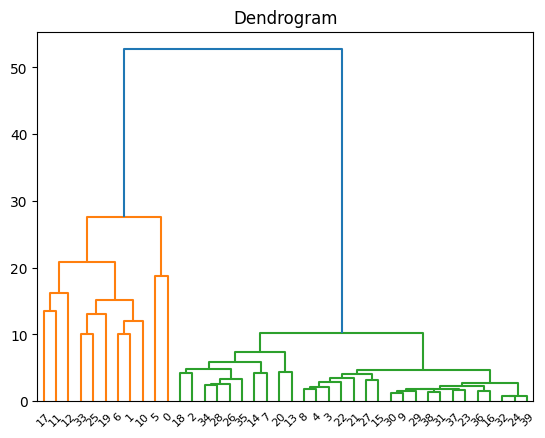

In [129]:
data_clust = np.array(pivoted_df)
linked = linkage(data_clust, method = 'ward')

dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp',
           p=40)
plt.title('Dendrogram')

In [130]:
### now cluster
n_clusters = 2
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  metric='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(data_clust)

### find mean pattern of each cluster
cluster_pattern = np.array([data_clust[cn==i].mean(axis=0) for i in range(n_clusters)])

## Once with Clusters we can try to identify PCA per cluster

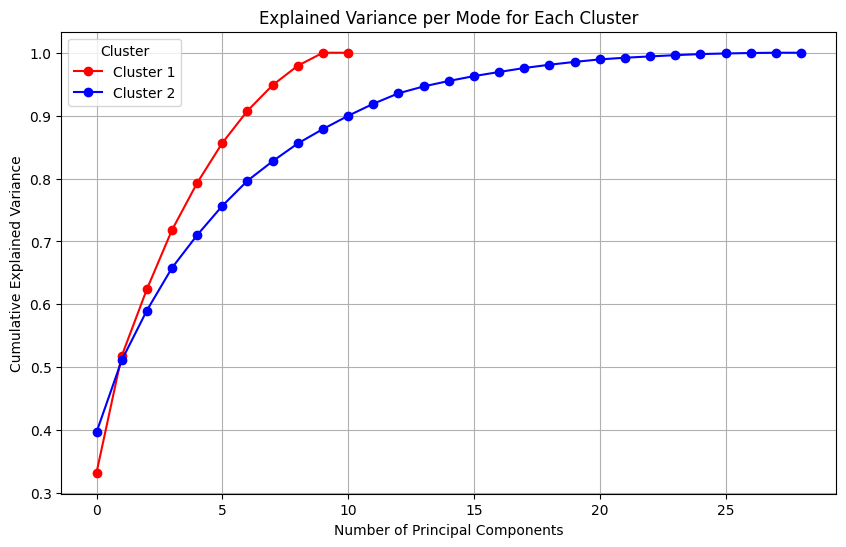

In [131]:
# Prepare the plot
plt.figure(figsize=(10, 6))

# Colors for the clusters
colors = ['red', 'blue']

# Loop through each cluster
for cluster_id in range(n_clusters):
    # Filter the data for the current cluster
    cluster_data = data_clust[cn == cluster_id]
    
    # Perform PCA
    pca = PCA()
    pca.fit(cluster_data)
    
    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # Plot the explained variance
    plt.plot(
        np.cumsum(explained_variance_ratio), 
        marker='o', 
        color=colors[cluster_id],
        label=f'Cluster {cluster_id + 1}'
    )

# Customize the plot
plt.title('Explained Variance per Mode for Each Cluster')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.legend(title='Cluster')
plt.show()

## CCA per Cluster

In [132]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

# Read the dataset
data = pd.read_csv('Datasets/combined_data.csv')

# Preprocess the Sta_ID column to round the second part to the nearest 10
def round_sta_id(value):
    parts = value.split()
    rounded_parts = [
        f"{float(part):.1f}" if i == 0 else f"{10 * round(float(part) / 10):.1f}"
        for i, part in enumerate(parts)
    ]
    return " ".join(rounded_parts)

data['Sta_ID'] = data['Sta_ID'].apply(round_sta_id)

# Filter Cluster 0 stations
cluster_0_stations = ['76.7 50.0', '76.7 60.0', '80.0 50.0', '80.0 60.0', '81.8 50.0', 
                       '83.3 40.0', '83.3 50.0', '86.7 30.0', '86.7 50.0', '90.0 30.0', 
                       '93.3 30.0']
filtered_data = data[data['Sta_ID'].isin(cluster_0_stations)]

# Drop rows with missing values for ChlorA and Depthm
filtered_data = filtered_data.dropna(subset=['ChlorA', 'Depthm'])


In [133]:
# Ensure we only keep numeric columns for the groupby operation
numeric_columns = ['ChlorA', 'Depthm']
filtered_numeric_data = filtered_data[['YearMonth', 'Sta_ID'] + numeric_columns]

# Group by YearMonth and Sta_ID, then calculate the mean for numeric columns
grouped_data = filtered_numeric_data.groupby(['YearMonth', 'Sta_ID'])[numeric_columns].mean().reset_index()

# Create separate dataframes for ChlorA and Depthm, pivoting Sta_ID into columns
chlor_a_df = grouped_data.pivot(index='YearMonth', columns='Sta_ID', values='ChlorA')
depth_m_df = grouped_data.pivot(index='YearMonth', columns='Sta_ID', values='Depthm')

In [134]:
depth_m_df = depth_m_df.dropna()
chlor_a_df = chlor_a_df.dropna()

In [135]:
# Fit the CCA model
cca = CCA(n_components=3)
X_c, Y_c = cca.fit_transform(chlor_a_df, depth_m_df)

# Extract mode weights
chlor_modes = cca.x_weights_
depth_modes = cca.y_weights_

# Calculate canonical correlations
correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(3)]
print("Canonical Correlations:", correlations)

Canonical Correlations: [np.float64(0.6219442004267293), np.float64(0.5673676973425483), np.float64(0.5513374280348866)]


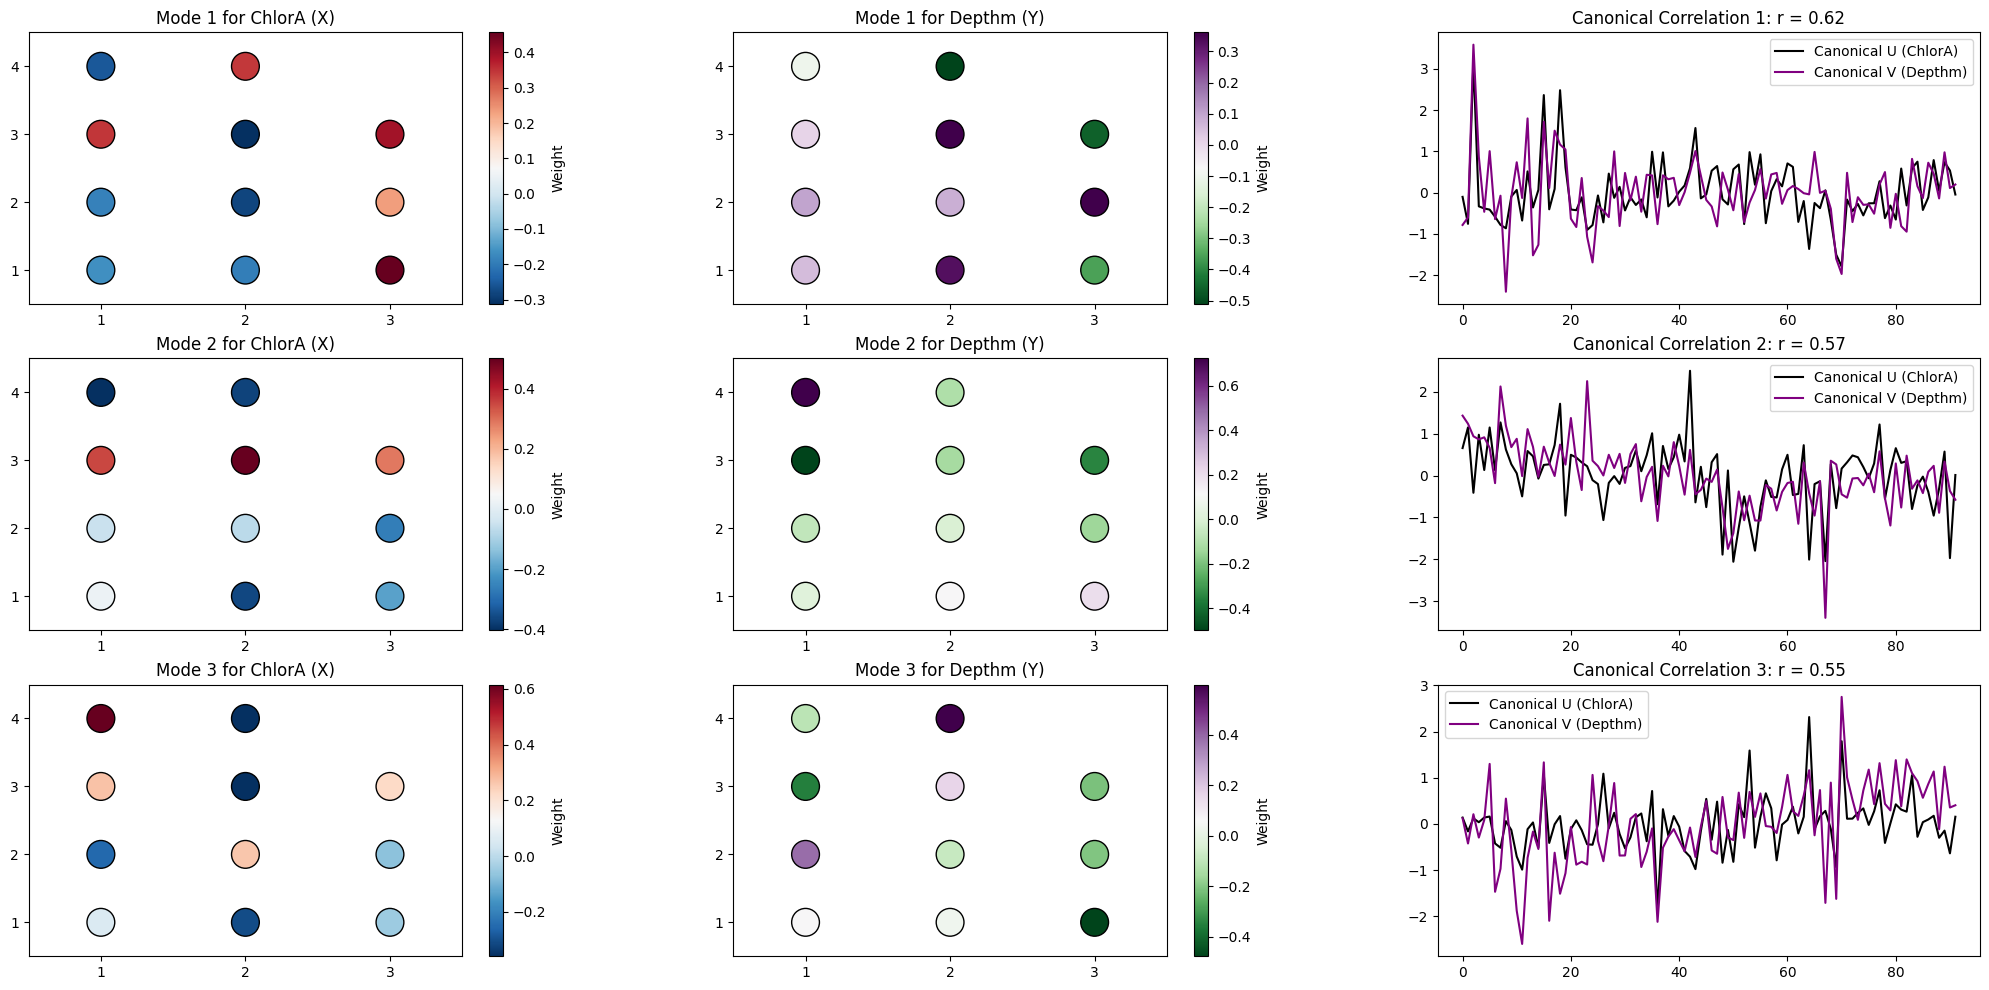

In [136]:
station_coordinates = [(j % 3 + 1, j // 3 + 1) for j in range(len(chlor_a_df.columns))]

# Plot the canonical modes and include colorbars with tighter layout
fig, axes = plt.subplots(3, 3, figsize=(20, 10))  # Maintain horizontal rectangle size
for i in range(3):  # For each canonical mode
    # Extract mode weights for ChlorA and Depthm
    chlor_mode = chlor_modes[:, i]
    depth_mode = depth_modes[:, i]

    # ChlorA scatter plot with colorbar using "RdBu_r"
    ax1 = axes[i, 0]
    scatter1 = ax1.scatter(
        *zip(*station_coordinates),
        c=chlor_mode,
        cmap="RdBu_r",  # Updated colormap
        s=400,  # Increase circle size
        edgecolors="k"
    )
    ax1.set_title(f"Mode {i + 1} for ChlorA (X)", fontsize=12)
    ax1.set_xlim(0.5, 3.5)
    ax1.set_ylim(0.5, (len(chlor_a_df.columns) // 3) + 1.5)
    ax1.set_xticks(range(1, 4))
    ax1.set_yticks(range(1, (len(chlor_a_df.columns) // 3) + 2))
    fig.colorbar(scatter1, ax=ax1, orientation="vertical", label="Weight")

    # Depthm scatter plot with colorbar using "PRGn_r"
    ax2 = axes[i, 1]
    scatter2 = ax2.scatter(
        *zip(*station_coordinates),
        c=depth_mode,
        cmap="PRGn_r",  # Updated colormap
        s=400,  # Increase circle size
        edgecolors="k"
    )
    ax2.set_title(f"Mode {i + 1} for Depthm (Y)", fontsize=12)
    ax2.set_xlim(0.5, 3.5)
    ax2.set_ylim(0.5, (len(depth_m_df.columns) // 3) + 1.5)
    ax2.set_xticks(range(1, 4))
    ax2.set_yticks(range(1, (len(depth_m_df.columns) // 3) + 2))
    fig.colorbar(scatter2, ax=ax2, orientation="vertical", label="Weight")

    # Canonical correlation plot using blue and purple
    ax3 = axes[i, 2]
    ax3.plot(X_c[:, i], label="Canonical U (ChlorA)", color="black")
    ax3.plot(Y_c[:, i], label="Canonical V (Depthm)", color="purple")
    ax3.set_title(f"Canonical Correlation {i + 1}: r = {correlations[i]:.2f}", fontsize=12)
    ax3.legend()

# Adjust layout for less blank space
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.2)  # Reduce space between subplots
plt.show()

Canonical Correlations: [np.float64(0.7720044153265061), np.float64(0.6910169697737923)]


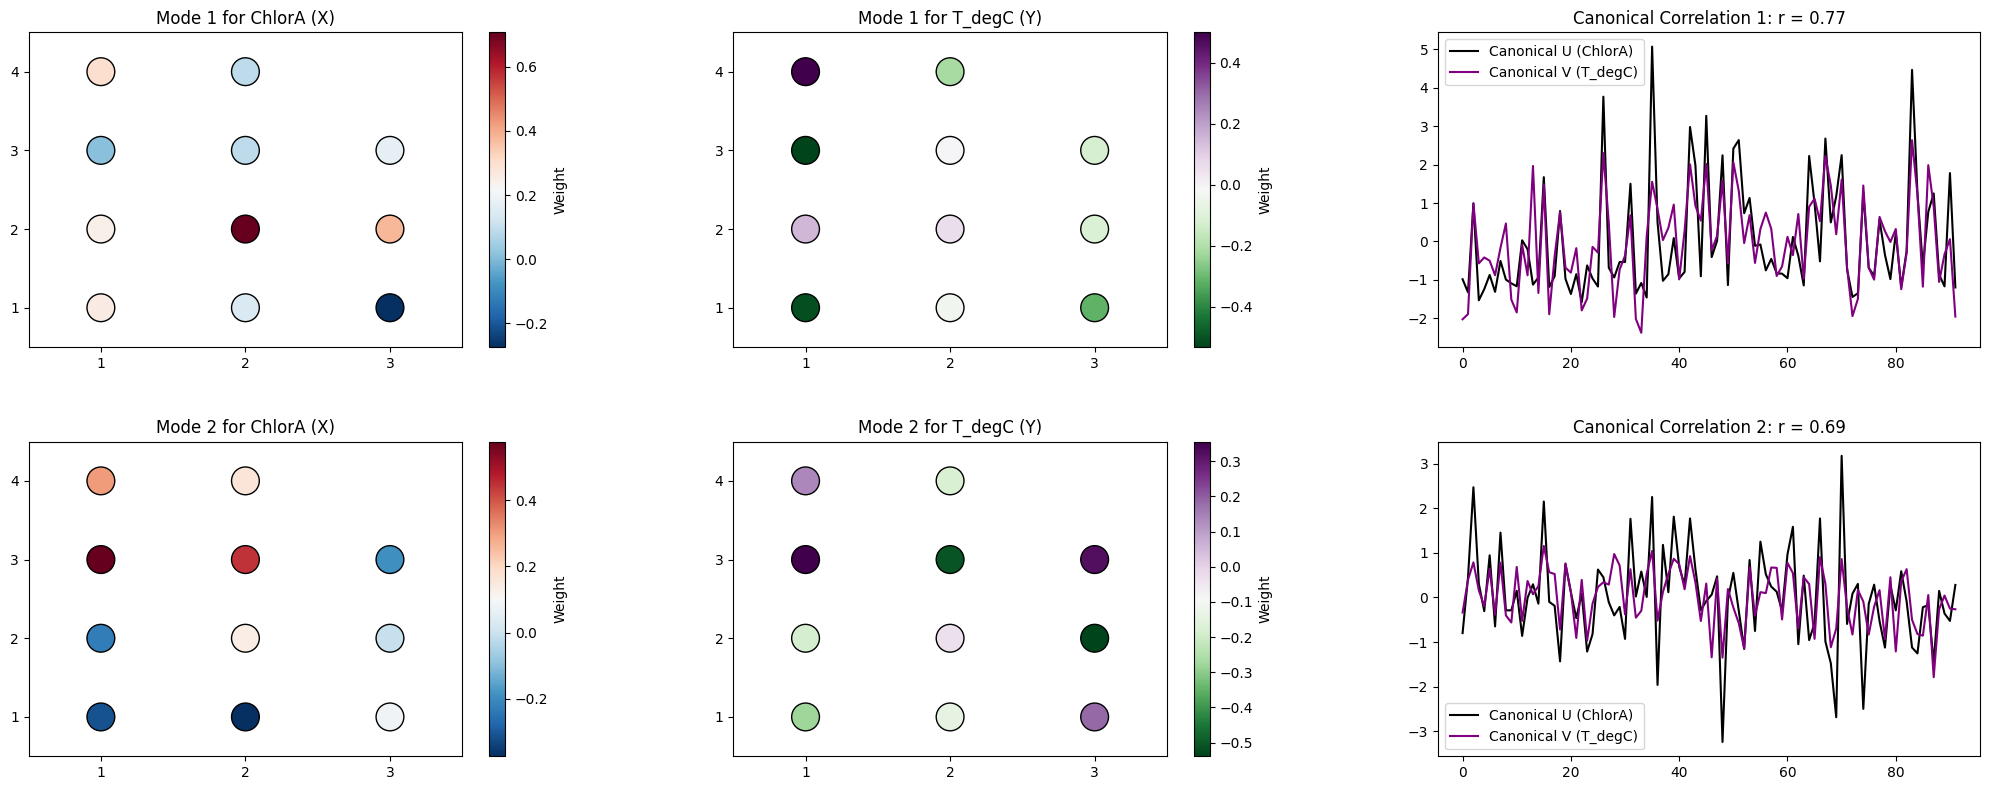

In [143]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

# Read the dataset
data = pd.read_csv('Datasets/combined_data.csv')

# Preprocess the Sta_ID column to round the second part to the nearest 10
def round_sta_id(value):
    parts = value.split()
    rounded_parts = [
        f"{float(part):.1f}" if i == 0 else f"{10 * round(float(part) / 10):.1f}"
        for i, part in enumerate(parts)
    ]
    return " ".join(rounded_parts)

data['Sta_ID'] = data['Sta_ID'].apply(round_sta_id)

# Filter Cluster 0 stations
cluster_0_stations = ['76.7 50.0', '76.7 60.0', '80.0 50.0', '80.0 60.0', '81.8 50.0', 
                       '83.3 40.0', '83.3 50.0', '86.7 30.0', '86.7 50.0', '90.0 30.0', 
                       '93.3 30.0']
filtered_data = data[data['Sta_ID'].isin(cluster_0_stations)]

# Drop rows with missing values for ChlorA and T_degC
filtered_data = filtered_data.dropna(subset=['ChlorA', 'T_degC'])

# Ensure we only keep numeric columns for the groupby operation
numeric_columns = ['ChlorA', 'T_degC']
filtered_numeric_data = filtered_data[['YearMonth', 'Sta_ID'] + numeric_columns]

# Group by YearMonth and Sta_ID, then calculate the mean for numeric columns
grouped_data = filtered_numeric_data.groupby(['YearMonth', 'Sta_ID'])[numeric_columns].mean().reset_index()

# Create separate dataframes for ChlorA and T_degC, pivoting Sta_ID into columns
chlor_a_df = grouped_data.pivot(index='YearMonth', columns='Sta_ID', values='ChlorA')
t_degC_df = grouped_data.pivot(index='YearMonth', columns='Sta_ID', values='T_degC')

t_degC_df = t_degC_df.dropna()
chlor_a_df = chlor_a_df.dropna()

# Ensure ChlorA and T_degC data have the same rows
chlor_a_df = chlor_a_df.loc[t_degC_df.index]

# Fit the CCA model
cca = CCA(n_components=2)  # Set to 2 modes
X_c, Y_c = cca.fit_transform(chlor_a_df, t_degC_df)

# Extract mode weights
chlor_modes = cca.x_weights_
t_degC_modes = cca.y_weights_

# Calculate canonical correlations
correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(2)]
print("Canonical Correlations:", correlations)

# Define station coordinates for plotting
station_coordinates = [(j % 3 + 1, j // 3 + 1) for j in range(len(chlor_a_df.columns))]

# Plot the canonical modes and include colorbars with tighter layout
fig, axes = plt.subplots(2, 3, figsize=(20, 8))  # Adjust for 2 modes
for i in range(2):  # For each canonical mode
    # Extract mode weights for ChlorA and T_degC
    chlor_mode = chlor_modes[:, i]
    t_degC_mode = t_degC_modes[:, i]

    # ChlorA scatter plot with colorbar using "RdBu_r"
    ax1 = axes[i, 0]
    scatter1 = ax1.scatter(
        *zip(*station_coordinates),
        c=chlor_mode,
        cmap="RdBu_r",  # Updated colormap
        s=400,  # Increase circle size
        edgecolors="k"
    )
    ax1.set_title(f"Mode {i + 1} for ChlorA (X)", fontsize=12)
    ax1.set_xlim(0.5, 3.5)
    ax1.set_ylim(0.5, (len(chlor_a_df.columns) // 3) + 1.5)
    ax1.set_xticks(range(1, 4))
    ax1.set_yticks(range(1, (len(chlor_a_df.columns) // 3) + 2))
    fig.colorbar(scatter1, ax=ax1, orientation="vertical", label="Weight")

    # T_degC scatter plot with colorbar using "PRGn_r"
    ax2 = axes[i, 1]
    scatter2 = ax2.scatter(
        *zip(*station_coordinates),
        c=t_degC_mode,
        cmap="PRGn_r",  # Updated colormap
        s=400,  # Increase circle size
        edgecolors="k"
    )
    ax2.set_title(f"Mode {i + 1} for T_degC (Y)", fontsize=12)
    ax2.set_xlim(0.5, 3.5)
    ax2.set_ylim(0.5, (len(t_degC_df.columns) // 3) + 1.5)
    ax2.set_xticks(range(1, 4))
    ax2.set_yticks(range(1, (len(t_degC_df.columns) // 3) + 2))
    fig.colorbar(scatter2, ax=ax2, orientation="vertical", label="Weight")

    # Canonical correlation plot using blue and purple
    ax3 = axes[i, 2]
    ax3.plot(X_c[:, i], label="Canonical U (ChlorA)", color="black")
    ax3.plot(Y_c[:, i], label="Canonical V (T_degC)", color="purple")
    ax3.set_title(f"Canonical Correlation {i + 1}: r = {correlations[i]:.2f}", fontsize=12)
    ax3.legend()

# Adjust layout for less blank space
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Reduce space between subplots
plt.show()

Canonical Correlations: [np.float64(0.7720044153265061), np.float64(0.6910169697737923)]


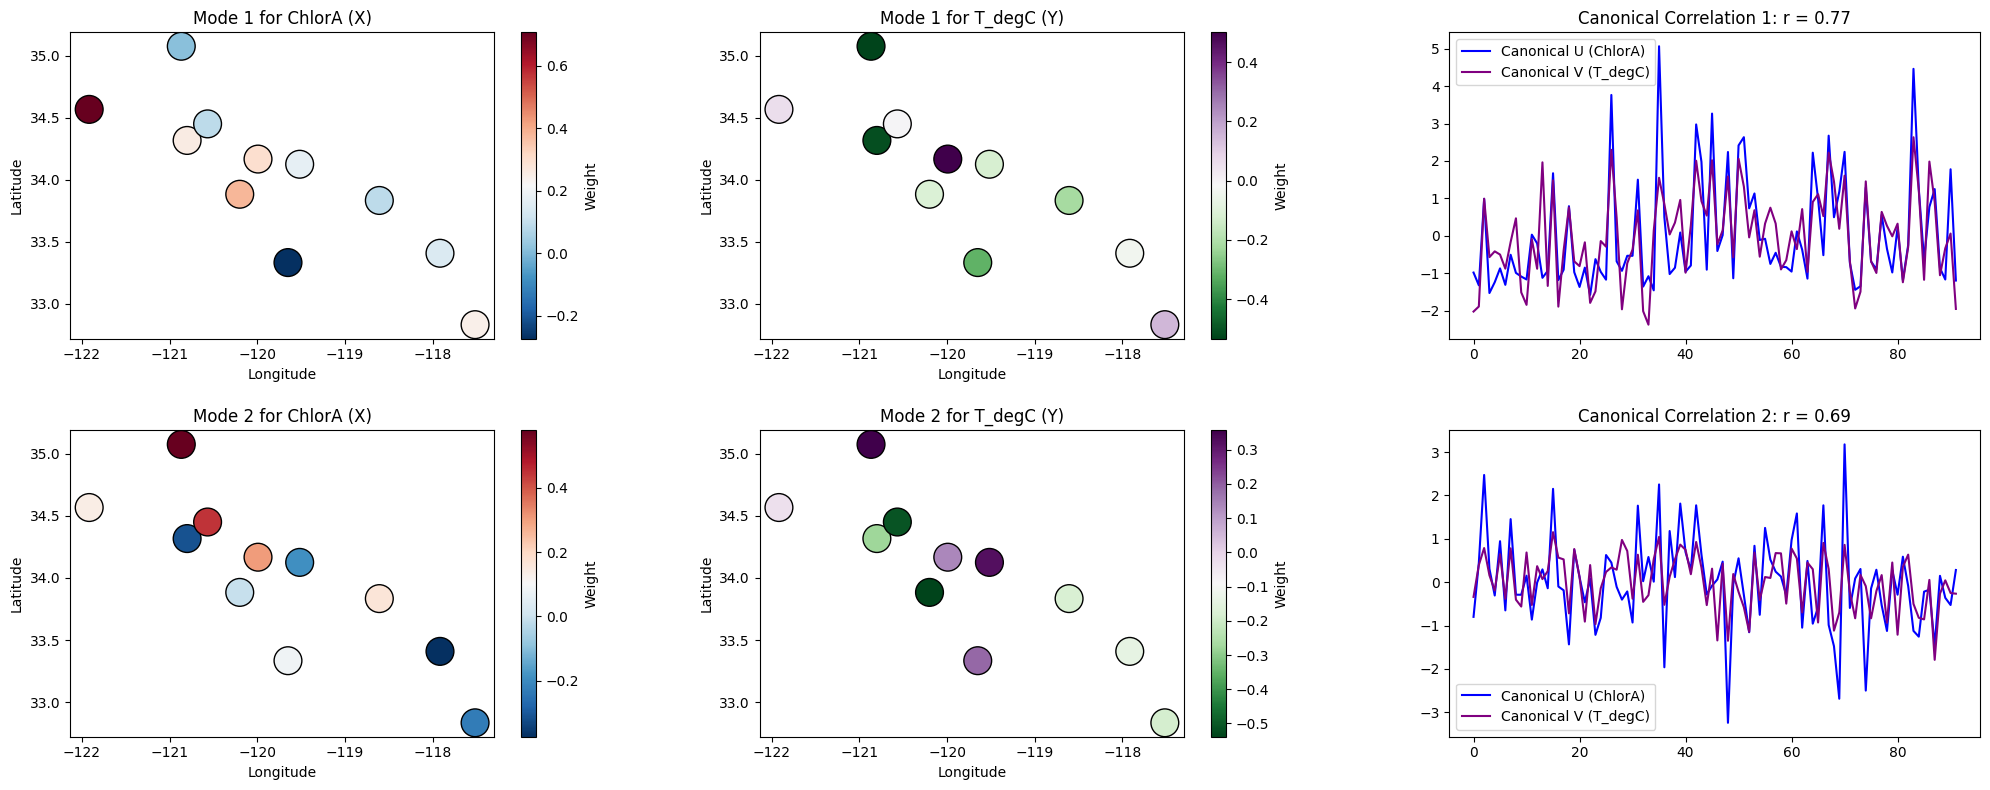

In [144]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

# Part 1: Process the main dataset (INTACT CODE)
data = pd.read_csv('Datasets/combined_data.csv')

# Preprocess the Sta_ID column to round the second part to the nearest 10
def round_sta_id(value):
    parts = value.split()
    rounded_parts = [
        f"{float(part):.1f}" if i == 0 else f"{10 * round(float(part) / 10):.1f}"
        for i, part in enumerate(parts)
    ]
    return " ".join(rounded_parts)

data['Sta_ID'] = data['Sta_ID'].apply(round_sta_id)

# Filter Cluster 0 stations
cluster_0_stations = ['76.7 50.0', '76.7 60.0', '80.0 50.0', '80.0 60.0', '81.8 50.0', 
                       '83.3 40.0', '83.3 50.0', '86.7 30.0', '86.7 50.0', '90.0 30.0', 
                       '93.3 30.0']
filtered_data = data[data['Sta_ID'].isin(cluster_0_stations)]

# Drop rows with missing values for ChlorA and T_degC
filtered_data = filtered_data.dropna(subset=['ChlorA', 'T_degC'])

# Ensure we only keep numeric columns for the groupby operation
numeric_columns = ['ChlorA', 'T_degC']
filtered_numeric_data = filtered_data[['YearMonth', 'Sta_ID'] + numeric_columns]

# Group by YearMonth and Sta_ID, then calculate the mean for numeric columns
grouped_data = filtered_numeric_data.groupby(['YearMonth', 'Sta_ID'])[numeric_columns].mean().reset_index()

# Create separate dataframes for ChlorA and T_degC, pivoting Sta_ID into columns
chlor_a_df = grouped_data.pivot(index='YearMonth', columns='Sta_ID', values='ChlorA')
t_degC_df = grouped_data.pivot(index='YearMonth', columns='Sta_ID', values='T_degC')

t_degC_df = t_degC_df.dropna()
chlor_a_df = chlor_a_df.dropna()

# Ensure ChlorA and T_degC data have the same rows
chlor_a_df = chlor_a_df.loc[t_degC_df.index]

# Fit the CCA model
cca = CCA(n_components=2)  # Set to 2 modes
X_c, Y_c = cca.fit_transform(chlor_a_df, t_degC_df)

# Extract mode weights
chlor_modes = cca.x_weights_
t_degC_modes = cca.y_weights_

# Calculate canonical correlations
correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(2)]
print("Canonical Correlations:", correlations)

# Part 2: Process the dataset again to extract unique station coordinates
coordinate_data = data[['Sta_ID', 'Lat_Dec', 'Lon_Dec']].dropna().drop_duplicates(subset='Sta_ID', keep='first')
coordinate_data = coordinate_data[coordinate_data['Sta_ID'].isin(cluster_0_stations)]

# Extract latitudes and longitudes for the 11 unique stations
latitudes = coordinate_data['Lat_Dec'].values
longitudes = coordinate_data['Lon_Dec'].values

# Part 3: Plotting with latitude and longitude
fig, axes = plt.subplots(2, 3, figsize=(20, 8))  # Adjust for 2 modes
for i in range(2):  # For each canonical mode
    # Extract mode weights for ChlorA and T_degC
    chlor_mode = cca.x_weights_[:, i]
    t_degC_mode = cca.y_weights_[:, i]

    # ChlorA scatter plot with colorbar using "RdBu_r"
    ax1 = axes[i, 0]
    scatter1 = ax1.scatter(
        longitudes,
        latitudes,
        c=chlor_mode[:len(latitudes)],  # Align weights with stations
        cmap="RdBu_r",
        s=400,  # Increase circle size
        edgecolors="k"
    )
    ax1.set_title(f"Mode {i + 1} for ChlorA (X)", fontsize=12)
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    fig.colorbar(scatter1, ax=ax1, orientation="vertical", label="Weight")

    # T_degC scatter plot with colorbar using "PRGn_r"
    ax2 = axes[i, 1]
    scatter2 = ax2.scatter(
        longitudes,
        latitudes,
        c=t_degC_mode[:len(latitudes)],  # Align weights with stations
        cmap="PRGn_r",
        s=400,  # Increase circle size
        edgecolors="k"
    )
    ax2.set_title(f"Mode {i + 1} for T_degC (Y)", fontsize=12)
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    fig.colorbar(scatter2, ax=ax2, orientation="vertical", label="Weight")

    # Canonical correlation plot using blue and purple
    ax3 = axes[i, 2]
    ax3.plot(X_c[:, i], label="Canonical U (ChlorA)", color="blue")
    ax3.plot(Y_c[:, i], label="Canonical V (T_degC)", color="purple")
    ax3.set_title(f"Canonical Correlation {i + 1}: r = {correlations[i]:.2f}", fontsize=12)
    ax3.legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Reduce space between subplots
plt.show()

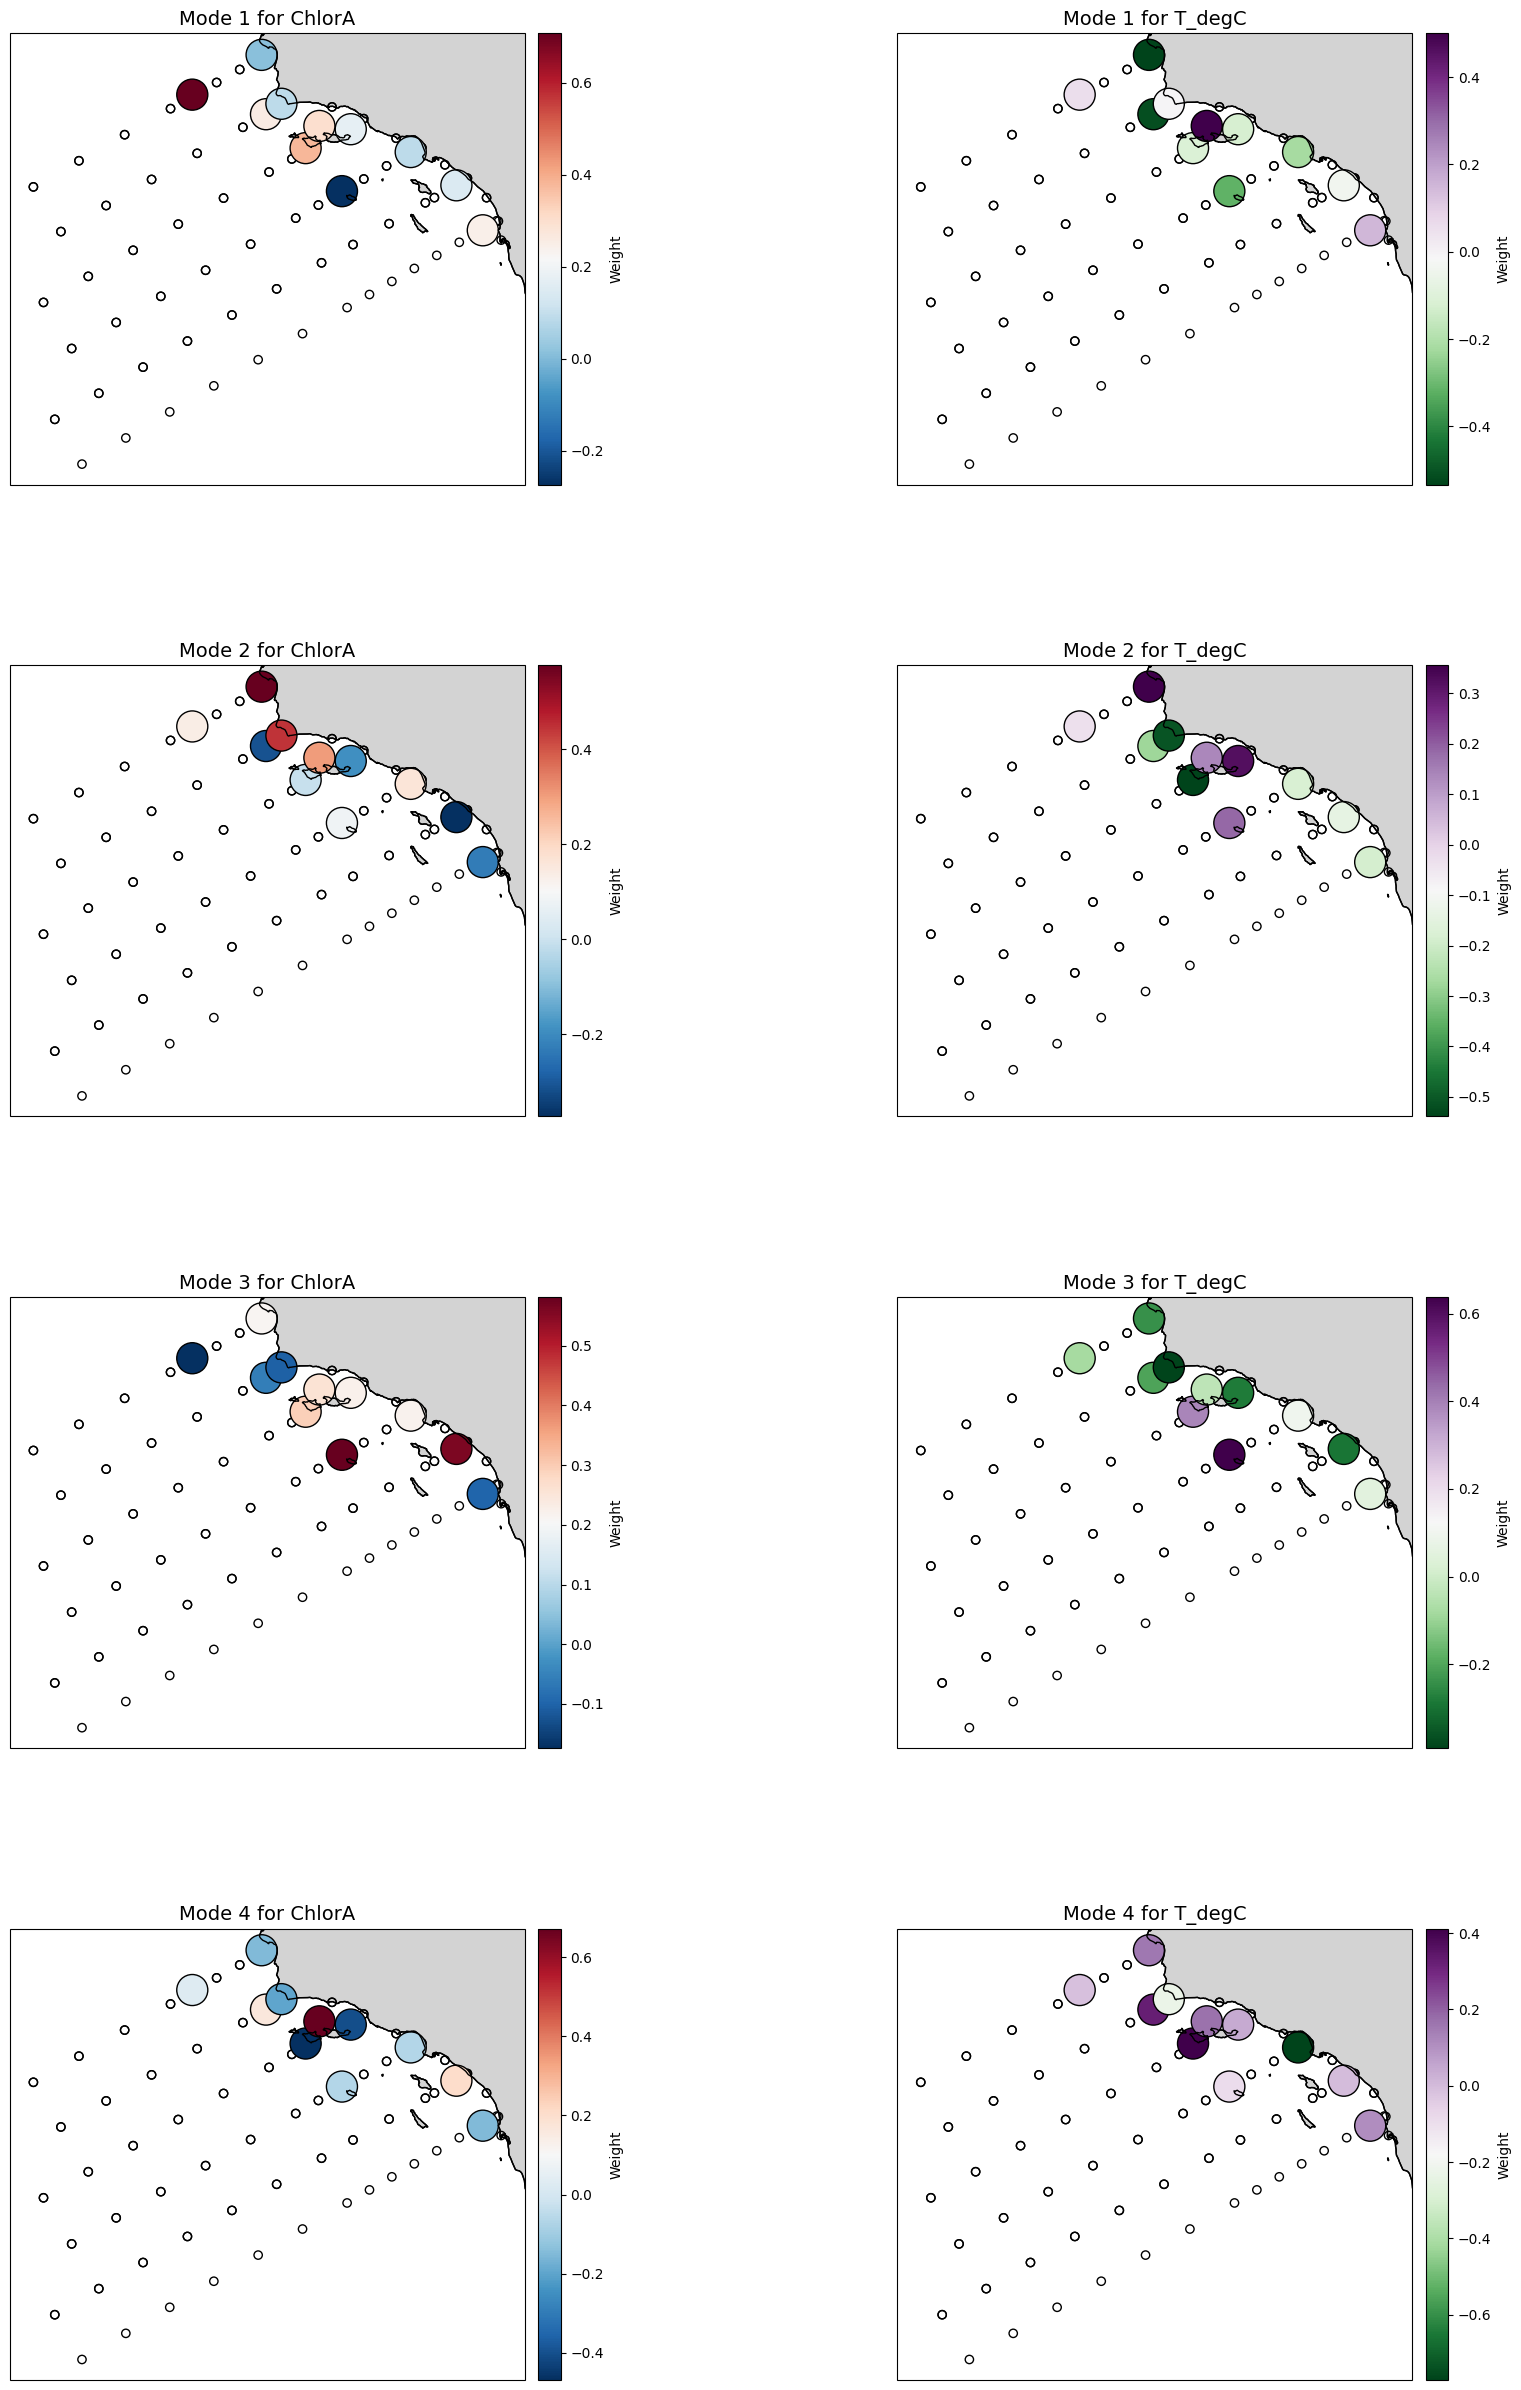

In [149]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Part 1: Process the main dataset (INTACT CODE)
data = pd.read_csv('Datasets/combined_data.csv')

def round_sta_id(value):
    parts = value.split()
    rounded_parts = [
        f"{float(part):.1f}" if i == 0 else f"{10 * round(float(part) / 10):.1f}"
        for i, part in enumerate(parts)
    ]
    return " ".join(rounded_parts)

data['Sta_ID'] = data['Sta_ID'].apply(round_sta_id)

cluster_0_stations = ['76.7 50.0', '76.7 60.0', '80.0 50.0', '80.0 60.0', '81.8 50.0', 
                       '83.3 40.0', '83.3 50.0', '86.7 30.0', '86.7 50.0', '90.0 30.0', 
                       '93.3 30.0']
filtered_data = data[data['Sta_ID'].isin(cluster_0_stations)]

filtered_data = filtered_data.dropna(subset=['ChlorA', 'T_degC'])

numeric_columns = ['ChlorA', 'T_degC']
filtered_numeric_data = filtered_data[['YearMonth', 'Sta_ID'] + numeric_columns]

grouped_data = filtered_numeric_data.groupby(['YearMonth', 'Sta_ID'])[numeric_columns].mean().reset_index()

chlor_a_df = grouped_data.pivot(index='YearMonth', columns='Sta_ID', values='ChlorA')
t_degC_df = grouped_data.pivot(index='YearMonth', columns='Sta_ID', values='T_degC')

t_degC_df = t_degC_df.dropna()
chlor_a_df = chlor_a_df.dropna()

chlor_a_df = chlor_a_df.loc[t_degC_df.index]

cca = CCA(n_components=4)
cca.fit(chlor_a_df, t_degC_df)

chlor_modes = cca.x_weights_
t_degC_modes = cca.y_weights_

# Part 2: Process unique coordinates
coordinate_data = data[['Sta_ID', 'Lat_Dec', 'Lon_Dec']].dropna().drop_duplicates(subset='Sta_ID', keep='first')
coordinate_data = coordinate_data[coordinate_data['Sta_ID'].isin(cluster_0_stations)]

latitudes = coordinate_data['Lat_Dec'].values
longitudes = coordinate_data['Lon_Dec'].values

# Part 3: Load shoreline map
gdf = gpd.read_file('Datasets/CalCOFI_75StandardStations.kml')
gdf = gdf.to_crs(epsg=4326)

# Part 4: Plot maps for all 4 modes
fig, axes = plt.subplots(4, 2, figsize=(16, 24), subplot_kw={'projection': ccrs.PlateCarree()})

for i in range(4):  # Loop through 4 modes
    # ChlorA with shoreline map
    ax1 = axes[i, 0]
    ax1.coastlines(resolution='10m', color='black')
    ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')
    gdf.plot(ax=ax1, transform=ccrs.PlateCarree(), color='none', edgecolor='black')
    scatter1 = ax1.scatter(
        longitudes,
        latitudes,
        c=chlor_modes[:, i],
        cmap="RdBu_r",
        s=500,
        edgecolors="k",
        transform=ccrs.PlateCarree()
    )
    ax1.set_title(f"Mode {i + 1} for ChlorA", fontsize=14)
    cbar1 = plt.colorbar(scatter1, ax=ax1, orientation='vertical', pad=0.02)
    cbar1.set_label('Weight')

    # T_degC with shoreline map
    ax2 = axes[i, 1]
    ax2.coastlines(resolution='10m', color='black')
    ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')
    gdf.plot(ax=ax2, transform=ccrs.PlateCarree(), color='none', edgecolor='black')
    scatter2 = ax2.scatter(
        longitudes,
        latitudes,
        c=t_degC_modes[:, i],
        cmap="PRGn_r",
        s=500,
        edgecolors="k",
        transform=ccrs.PlateCarree()
    )
    ax2.set_title(f"Mode {i + 1} for T_degC", fontsize=14)
    cbar2 = plt.colorbar(scatter2, ax=ax2, orientation='vertical', pad=0.02)
    cbar2.set_label('Weight')

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing
plt.show()